<a href="https://colab.research.google.com/github/Aryannovice/mY_FIRST/blob/main/Brain_tumor_classification/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aryannovice","key":"b690b0878cd24bd209b82ff6cbb028c8"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

ref                                                          title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
muhammadroshaanriaz/students-performance-dataset-cleaned     Students Performance | Clean Dataset               10KB  2024-10-29 19:32:26           3770         71  1.0              
valakhorasani/mobile-device-usage-and-user-behavior-dataset  Mobile Device Usage and User Behavior Dataset      11KB  2024-09-28 20:21:12          24404        491  1.0              
valakhorasani/gym-members-exercise-dataset                   Gym Members Exercise Dataset                       22KB  2024-10-06 11:27:38          14072        201  1.0              
zeeshier/weather-forecast-dataset                            Weather Forecast Dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("denizkavi1/brain-tumor")

print("Path to dataset files:", path)

100%|██████████| 700M/700M [00:04<00:00, 177MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/denizkavi1/brain-tumor/versions/2


In [ ]:
!kaggle datasets download -d denizkavi1/brain-tumor

Dataset URL: https://www.kaggle.com/datasets/denizkavi1/brain-tumor
License(s): Attribution 4.0 International (CC BY 4.0)
 96% 674M/700M [00:02<00:00, 333MB/s]
100% 700M/700M [00:02<00:00, 305MB/s]


In [ ]:
!unzip brain-tumor.zip

Archive:  brain-tumor.zip
  inflating: 1/2300.png              
  inflating: 1/2301.png              
  inflating: 1/2302.png              
  inflating: 1/2303.png              
  inflating: 1/2304.png              
  inflating: 1/2305.png              
  inflating: 1/2306.png              
  inflating: 1/2307.png              
  inflating: 1/2308.png              
  inflating: 1/2309.png              
  inflating: 1/2310.png              
  inflating: 1/2311.png              
  inflating: 1/2312.png              
  inflating: 1/2313.png              
  inflating: 1/2314.png              
  inflating: 1/2315.png              
  inflating: 1/2316.png              
  inflating: 1/2317.png              
  inflating: 1/2318.png              
  inflating: 1/2319.png              
  inflating: 1/2320.png              
  inflating: 1/2321.png              
  inflating: 1/2322.png              
  inflating: 1/2323.png              
  inflating: 1/2324.png              
  inflating: 1/2325.png 

In [ ]:
!pip install tensorflow_addons
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import cv2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.2 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# Seed for reproducibility
def seed_everything(seed=0):
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything()

In [ ]:
# Parameters
IMAGE_SIZE = 224
BATCH_SIZE = 16
N_CLASSES = 3
EPOCHS = 30
import zipfile

# Unzip the data
with zipfile.ZipFile(TRAIN_PATH, 'r') as zip_ref:
    zip_ref.extractall('/content/brain-tumor') # Extract to a directory

# Update the TRAIN_PATH to the extracted directory
TRAIN_PATH = "/content/brain-tumor"

# Rest of your code using train_gen and valid_gen ...

# Label Mapping
CLASSES = {0: "Meningioma", 1: "Glioma", 2: "Pituitary Tumor"}

In [ ]:
def data_augment(image):
    # Random flips and rotations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    # Pixel-level augmentations
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image

In [ ]:
# Data Generators
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    preprocessing_function=data_augment
)

train_gen = datagen.flow_from_directory(
    TRAIN_PATH, target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, class_mode='categorical',
    subset='training', shuffle=True
)

valid_gen = datagen.flow_from_directory(
    TRAIN_PATH, target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, class_mode='categorical',
    subset='validation', shuffle=False
)

Found 2452 images belonging to 3 classes.
Found 612 images belonging to 3 classes.


In [ ]:
def build_model():
    base_model = tf.keras.applications.ResNet50V2(
        include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), pooling='avg', weights='imagenet'
    )
    base_model.trainable = False
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation=tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation=tfa.activations.gelu),
        tf.keras.layers.Dense(N_CLASSES, activation='softmax')
    ])
    return model

In [ ]:
model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    metrics=['accuracy']
)

94668760/94668760 [==============================] - 0s 0us/step


In [ ]:
# Training the Model
history = model.fit(
    train_gen, validation_data=valid_gen, epochs=EPOCHS,
    steps_per_epoch=train_gen.samples // BATCH_SIZE,
    validation_steps=valid_gen.samples // BATCH_SIZE
)

Epoch 1/30
153/153 [==============================] - 92s 574ms/step - loss: 0.9644 - accuracy: 0.6498 - val_loss: 0.8566 - val_accuracy: 0.7336
Epoch 2/30
153/153 [==============================] - 87s 567ms/step - loss: 0.8175 - accuracy: 0.7557 - val_loss: 0.8304 - val_accuracy: 0.7566
Epoch 3/30
153/153 [==============================] - 86s 560ms/step - loss: 0.7676 - accuracy: 0.7931 - val_loss: 0.8441 - val_accuracy: 0.7368
Epoch 4/30
153/153 [==============================] - 86s 562ms/step - loss: 0.7520 - accuracy: 0.8091 - val_loss: 0.8640 - val_accuracy: 0.7467
Epoch 5/30
153/153 [==============================] - 87s 566ms/step - loss: 0.7274 - accuracy: 0.8374 - val_loss: 0.8691 - val_accuracy: 0.7484
Epoch 6/30
153/153 [==============================] - 86s 562ms/step - loss: 0.7158 - accuracy: 0.8366 - val_loss: 0.8501 - val_accuracy: 0.7549
Epoch 7/30
153/153 [==============================] - 85s 557ms/step - loss: 0.6989 - accuracy: 0.8612 - val_loss: 0.7937 - val_ac

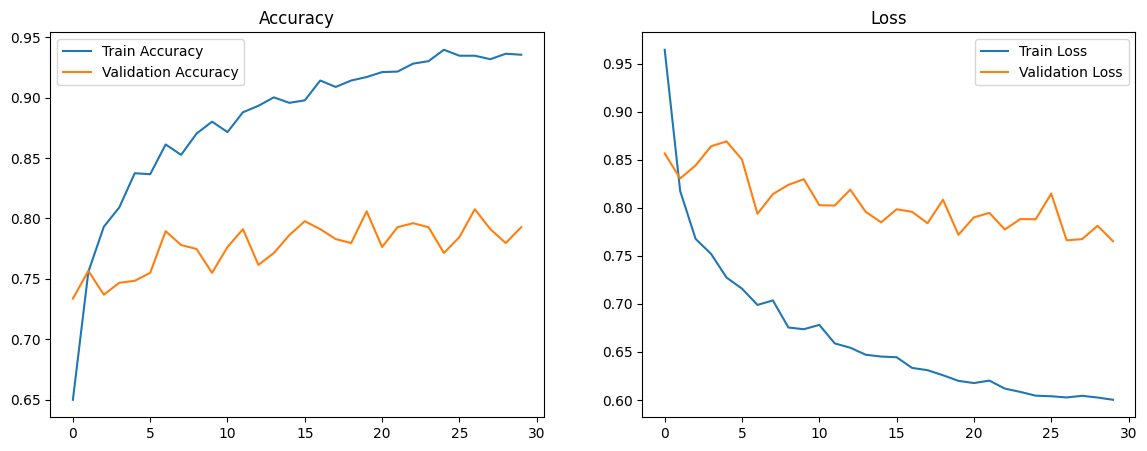

In [ ]:
# Plotting Training History
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()


39/39 [==============================] - 19s 452ms/step


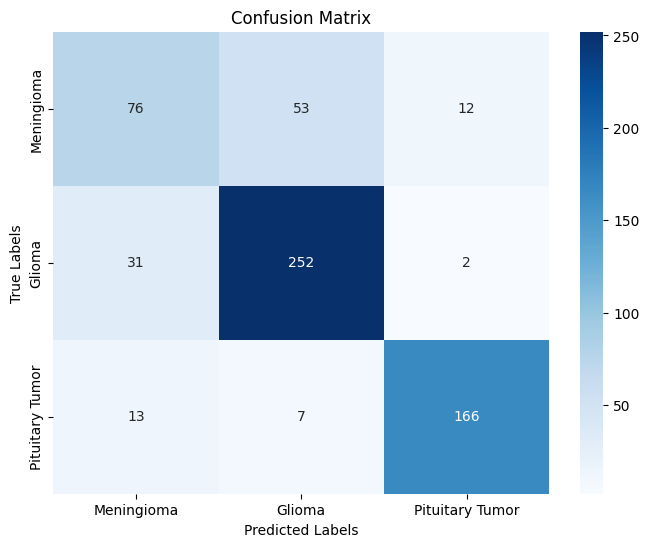

In [ ]:
# Model Evaluation
predictions = np.argmax(model.predict(valid_gen), axis=1)
true_labels = valid_gen.classes
conf_matrix = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[CLASSES[i] for i in range(N_CLASSES)],
            yticklabels=[CLASSES[i] for i in range(N_CLASSES)])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print(classification_report(true_labels, predictions, target_names=[CLASSES[i] for i in range(N_CLASSES)]))

                 precision    recall  f1-score   support

     Meningioma       0.63      0.54      0.58       141
         Glioma       0.81      0.88      0.84       285
Pituitary Tumor       0.92      0.89      0.91       186

       accuracy                           0.81       612
      macro avg       0.79      0.77      0.78       612
   weighted avg       0.80      0.81      0.80       612



Processing image 1/10: /content/1/2891.png


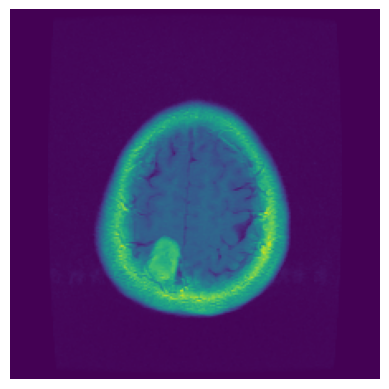

1/1 [==============================] - 0s 79ms/step
The predicted tumor type is: Meningioma and a tissue side
Processing image 2/10: /content/1/2668.png


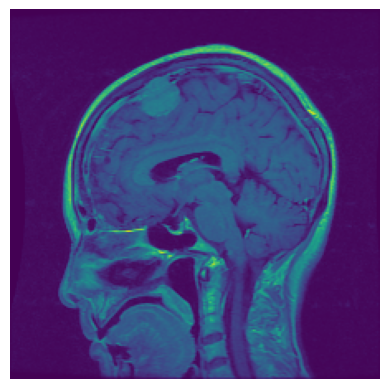

1/1 [==============================] - 0s 77ms/step
The predicted tumor type is: Meningioma and a tissue side
Processing image 3/10: /content/1/2618.png


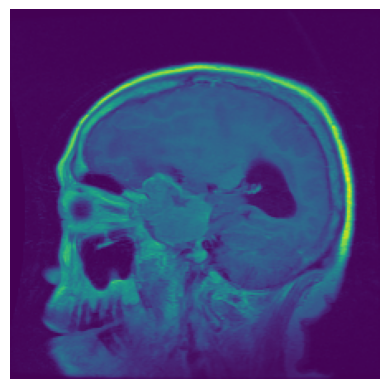

1/1 [==============================] - 0s 76ms/step
The predicted tumor type is: Meningioma and a tissue side
Processing image 4/10: /content/1/2833.png


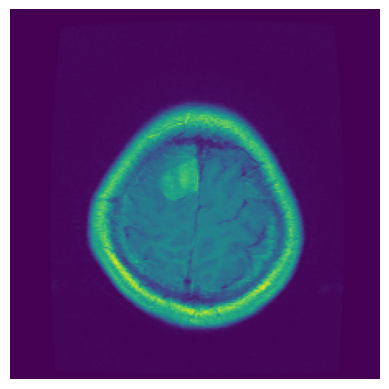

1/1 [==============================] - 0s 73ms/step
The predicted tumor type is: Meningioma and a tissue side
Processing image 5/10: /content/1/2480.png


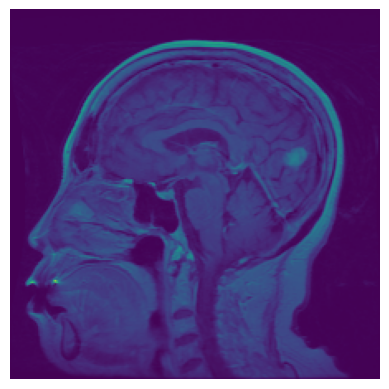

1/1 [==============================] - 0s 75ms/step
The predicted tumor type is: Meningioma and a tissue side
Processing image 6/10: /content/1/2944.png


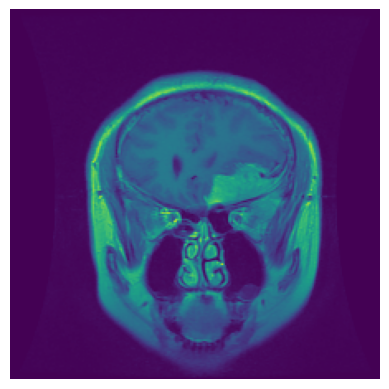

1/1 [==============================] - 0s 80ms/step
The predicted tumor type is: Meningioma and a tissue side
Processing image 7/10: /content/1/2889.png


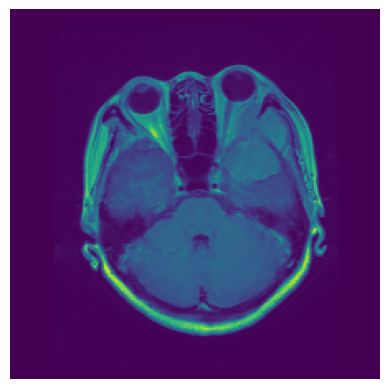

1/1 [==============================] - 0s 74ms/step
The predicted tumor type is: Meningioma and a tissue side
Processing image 8/10: /content/1/2553.png


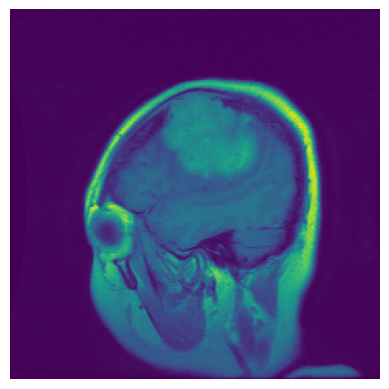

1/1 [==============================] - 0s 78ms/step
The predicted tumor type is: Meningioma and a tissue side
Processing image 9/10: /content/1/2494.png


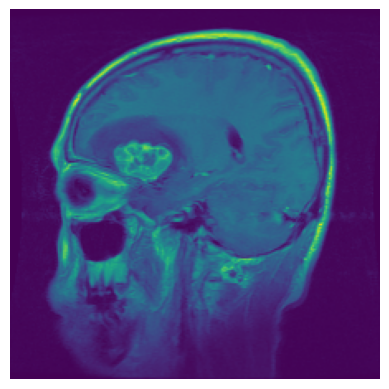

1/1 [==============================] - 0s 78ms/step
The predicted tumor type is: Meningioma and a tissue side
Processing image 10/10: /content/1/2646.png


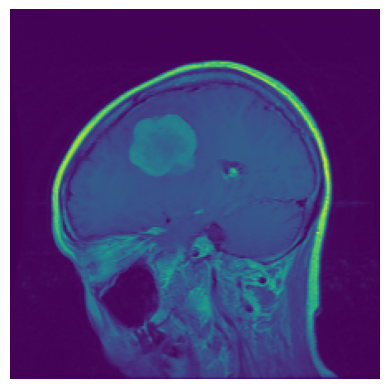

1/1 [==============================] - 0s 80ms/step
The predicted tumor type is: Glioma and a vessel side possibility


In [ ]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import glob

# Define the classes and the possible side types
CLASSES = {0: "Meningioma", 1: "Glioma", 2: "Pituitary Tumor"}
IMAGE_SIZE = 224  # or whatever size you use for the input image

def predict_image(image_path, model):
    # Load and preprocess the image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB format
    resized = tf.image.resize(img_rgb, (IMAGE_SIZE, IMAGE_SIZE))

    # Display the image
    plt.imshow(resized.numpy().astype(np.uint8))
    plt.axis('off')
    plt.show()

    # Make a prediction
    yhat = model.predict(np.expand_dims(resized / 255.0, 0))  # Normalize and predict
    predicted_class = CLASSES[np.argmax(yhat)]

    # Output the predicted tumor type and its side type
    if predicted_class == "Glioma":
        print(f"The predicted tumor type is: {predicted_class} and a vessel side possibility")
    else:
        print(f"The predicted tumor type is: {predicted_class} and a tissue side")

def predict_multiple_images(image_folder, model, num_images=10, randomize=True):
    # Get a list of all image paths in the directory
    image_paths = glob.glob(os.path.join(image_folder, '*.png'))  # Modify this extension based on your image types

    if randomize:
        # Shuffle the image list if we are picking random images
        random.shuffle(image_paths)

    # Loop over the first 'num_images' images
    for i, image_path in enumerate(image_paths[:num_images]):
        print(f"Processing image {i+1}/{num_images}: {image_path}")
        predict_image(image_path, model)

# Example usage:
predict_multiple_images('/content/1', model, num_images=10, randomize=True)
